In [21]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import matplotlib

In [8]:
transactions = pd.read_csv("mj-clean.csv", parse_dates=[5])
transactions.head()

,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [18]:
def GroupByQualityAndDay(transactions):
    groups = transactions.groupby('quality')
    dailies = {}
    for name, group in groups:
        dailies[name] = GroupByDay(group)
    
    return dailies

dailies = GroupByQualityAndDay(transactions)

In [15]:
def GroupByDay(transactions, func=np.mean):
    grouped = transactions[['date', 'ppg']].groupby('date')
    daily = grouped.aggregate(func)
    
    daily['date'] = daily.index
    start = daily.date[0]
    one_year = np.timedelta64(1, 'Y')
    daily['years'] = (daily.date - start) / one_year
    
    return daily

GroupByDay(transactions, func=np.mean)

,ppg,date,years
date,,,
2010-09-02,11.727733,2010-09-02,0.000000
2010-09-03,11.972892,2010-09-03,0.002738
2010-09-04,13.752500,2010-09-04,0.005476
2010-09-05,15.113333,2010-09-05,0.008214
2010-09-06,15.537500,2010-09-06,0.010952
...,...,...,...
2014-05-09,10.550241,2014-05-09,3.682485
2014-05-10,9.823366,2014-05-10,3.685223
2014-05-11,9.626667,2014-05-11,3.687961


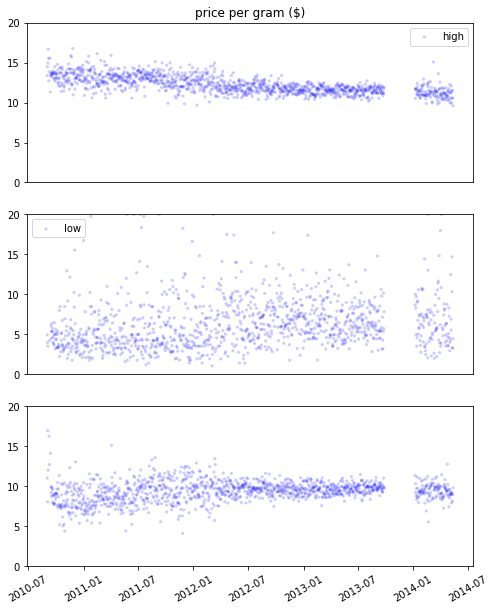

In [23]:
from matplotlib import pyplot

thinkplot.PrePlot(rows=3)
for i, (name, daily) in enumerate(dailies.items()):
    thinkplot.SubPlot(i+1)
    title = 'price per gram ($)' if i==0 else ''
    thinkplot.Config(ylim=[0, 20], title=title)
    thinkplot.Scatter(daily.index, daily.ppg, s=10, label=name)
    if i == 2:
        pyplot.xticks(rotation=30)
    else:
        thinkplot.Config(xticks=[])

In [35]:
import statsmodels.formula.api as smf
import chap01soln
import regression

def RunLinearModel(daily):
    model = smf.ols('ppg ~ years', data=daily)
    results = model.fit()
    return model, results

for name, daily in dailies.items():
    model, results = RunLinearModel(daily)
    print(name)
    regression.SummarizeResults(results)

high
Intercept   13.4   (0)
years   -0.708   (3.69e-160)
R^2 0.4441
Std(ys) 1.096
Std(res) 0.8174
low
Intercept   5.36   (3.15e-130)
years   0.568   (2.76e-09)
R^2 0.0296
Std(ys) 3.381
Std(res) 3.332
medium
Intercept   8.88   (0)
years   0.283   (1.82e-15)
R^2 0.0499
Std(ys) 1.304
Std(res) 1.272


In [36]:
def PlotFittedValues(model, results, label=''):
    years = model.exog[:,1]
    values = model.endog
    thinkplot.Scatter(years, values, s=15, label=label)
    thinkplot.Plot(years, results.fittedvalues, label='model')

In [63]:
array = np.arange(10)

series = pd.Series(array)
series.rolling(3).mean()

0    NaN
1    NaN
2    1.0
3    2.0
4    3.0
5    4.0
6    5.0
7    6.0
8    7.0
9    8.0
dtype: float64

In [64]:
dates = pd.date_range(daily.index.min(), daily.index.max())
reindexed = daily.reindex(dates)

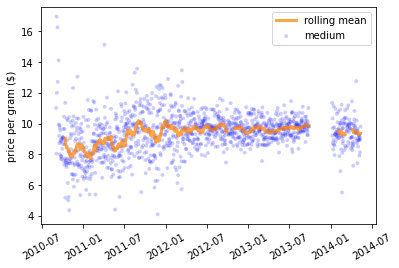

In [71]:
import matplotlib.pyplot as plt

def PlotRollingMean(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = pd.Series(reindexed.ppg).rolling(30).mean()
    thinkplot.Plot(roll_mean, label="rolling mean", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")
    
PlotRollingMean(daily, name)

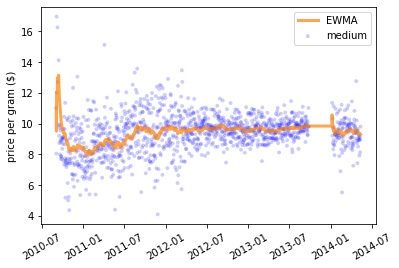

In [73]:
def PlotEWMA(daily, name):
    """Plots rolling mean.

    daily: DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    thinkplot.Scatter(reindexed.ppg, s=15, alpha=0.2, label=name)
    roll_mean = reindexed.ppg.ewm(30).mean()
    thinkplot.Plot(roll_mean, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="price per gram ($)")
    
PlotEWMA(daily, name)

In [81]:
def FillMissing(daily, span=30):
    """Fills missing values with an exponentially weighted moving average.

    Resulting DataFrame has new columns 'ewma' and 'resid'.

    daily: DataFrame of daily prices
    span: window size (sort of) passed to ewma

    returns: new DataFrame of daily prices
    """
    dates = pd.date_range(daily.index.min(), daily.index.max())
    reindexed = daily.reindex(dates)

    ewma = pd.Series(reindexed.ppg).ewm(span=span).mean()

    resid = (reindexed.ppg - ewma).dropna()
    fake_data = ewma + thinkstats2.Resample(resid, len(reindexed))
    reindexed.ppg.fillna(fake_data, inplace=True)

    reindexed["ewma"] = ewma
    reindexed["resid"] = reindexed.ppg - ewma
    return reindexed

FillMissing(daily)

,ppg,date,years,ewma,resid
2010-09-02,11.021250,2010-09-02,0.000000,11.021250,0.000000
2010-09-03,8.055000,2010-09-03,0.002738,9.488688,-1.433688
2010-09-04,16.950000,2010-09-04,0.005476,12.143379,4.806621
2010-09-05,12.005000,2010-09-05,0.008214,12.105250,-0.100250
2010-09-06,12.853824,NaT,NaN,12.105250,0.748574
...,...,...,...,...,...
2014-05-09,9.037059,2014-05-09,3.682485,9.205081,-0.168022
2014-05-10,9.155686,2014-05-10,3.685223,9.201887,-0.046201
2014-05-11,8.138214,2014-05-11,3.687961,9.133127,-0.994912
2014-05-12,8.959655,2014-05-12,3.690699,9.121914,-0.162259


In [76]:
def PlotFilled(daily, name):
    """Plots the EWMA and filled data.

    daily: DataFrame of daily prices
    """
    filled = FillMissing(daily, span=30)
    thinkplot.Scatter(filled.ppg, s=15, alpha=0.2, label=name)
    thinkplot.Plot(filled.ewma, label="EWMA", color="#ff7f00")
    plt.xticks(rotation=30)
    thinkplot.Config(ylabel="Price per gram ($)")

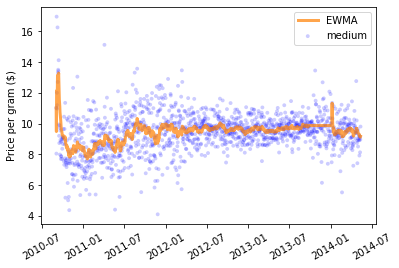

In [77]:
PlotFilled(daily, name)

In [78]:
def SerialCorr(series, lag=1):
    xs = series[lag:]
    ys = series.shift(lag)[lag:]
    corr = thinkstats2.Corr(xs, ys)
    return corr

In [84]:
filled_dailies = {}
for name, daily in dailies.items():
    filled_dailies[name] = FillMissing(daily, span=30)

In [85]:
for name, filled in filled_dailies.items():
    corr = thinkstats2.SerialCorr(filled.ppg, lag=1)
    print(name, corr)

high 0.488882668059474
low 0.12055355498124654
medium 0.17970282463574264


In [86]:
for name, filled in filled_dailies.items():
    corr = thinkstats2.SerialCorr(filled.resid, lag=1)
    print(name, corr)

high -0.010050397181504477
low 0.045909058518646455
medium -0.01565729915992642


In [87]:
rows = []
for lag in [1, 7, 30, 365]:
    print(lag, end="\t")
    for name, filled in filled_dailies.items():
        corr = SerialCorr(filled.resid, lag)
        print("%.2g" % corr, end="\t")
    print()

1	-0.01	0.046	-0.016	
7	0.0058	-0.02	-0.04	
30	0.0043	-0.019	-0.0018	
365	0.082	0.015	0.012	


In [89]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [90]:
import statsmodels.tsa.stattools as smtsa

filled = filled_dailies["high"]
acf = smtsa.acf(filled.resid, nlags=365, unbiased=True, fft=False)
print("%0.2g, %.2g, %0.2g, %0.2g, %0.2g" % (acf[0], acf[1], acf[7], acf[30], acf[365]))

1, -0.01, 0.0058, 0.0043, 0.08
